In [1]:
#Preocessing data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Machine learning algortihms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

#Kfolds
from sklearn.model_selection import StratifiedKFold

#More validation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import auc

#Make large numpy arrays look good
np.set_printoptions(linewidth=100, threshold=np.inf, suppress=True)

#load diabetes data
d = pd.read_csv("diabetes.csv")
d.head(100)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
95,6,144,72,27,228,33.9,0.255,40,0
96,2,92,62,28,0,31.6,0.130,24,0
97,1,71,48,18,76,20.4,0.323,22,0
98,6,93,50,30,64,28.7,0.356,23,0


In [2]:
#Seperate the target variable y (Diabetes yes or no) from the rest of the data (8 predicting variables),
#and standardize the predictive data
xunscaled = d.drop('Outcome',axis = 'columns')
scaler = StandardScaler()
X = scaler.fit_transform(xunscaled)
y = np.array(d['Outcome'])

In [3]:
#Random Forest CLassifier
rf = RandomForestClassifier(n_estimators=80, criterion = "entropy", min_samples_split=2)
#Support Vector Classifier
sv = SVC(C=2,kernel="rbf")
#LSTM Neural Net
lstm = Sequential()
lstm.add(Input(shape=(1, 8)))
lstm.add(LSTM(64))
lstm.add(Dense(1))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
#Create a function which will call all the metrics we want
def metrics(cm,modelpre):
        tp = cm[0][0]
        tn = cm[1][1]
        fp = cm[1][0]
        fn = cm[0][1]
        pos = tp + fn
        neg = tn + fp
        tpr = tp/(tp+fn)
        tnr = tn/(tn+fp)
        fpr = fp/(tn+fp)
        fnr = fn/(tp+fn)
        bacc = round((tpr+tnr)/2,2)
        tss = round(tpr - fpr,2)
        hss = round((2*(tp*tn-fp*fn))/((tp+fn)*(fn+tn)+(tp+fp)*(fp+tn)),2)
        recall = round(tpr,2)
        prec = round(tp/(tp + fp),2)
        f1 = round(2*(prec*recall)/(prec+recall),2)
        acc = round((tp + tn)/(pos + neg),2)
        err = round((fp + fn)/(pos + neg),2)
        fpr2, tpr2, _ = roc_curve(yte, modelpre)
        area = round(auc(fpr2, tpr2),2)
        results = {'Recall': recall, 'Precision': prec, 'Accuracy': acc,
               'Error Rate': err, 'F1-Score': f1, 'TSS': tss, 'HSS': hss, 'BACC': bacc, 'AUC': area}
        return results

In [5]:
#Create a function which will train and test the models within KFolds loop
def run(model,xtr,xte,ytr,yte,NN):
    if NN == 1:
        #Add "time" dimension for LSTM
        xtrnn = xtr.reshape((xtr.shape[0], 1, xtr.shape[1]))
        xtenn = xte.reshape((xte.shape[0], 1, xte.shape[1]))
        #Fit
        model.fit(xtrnn,ytr,epochs=50,validation_data=(xtenn,yte))
        models = model.evaluate(xtenn,yte)
        modelpre = model.predict(xtenn)
        #Separate the continous NN outputs into 2 classes
        modelpre = (modelpre > 0.5).astype(int)
        cm = confusion_matrix(yte,modelpre)
        return metrics(cm,modelpre)
    else:
        model.fit(xtr,ytr)
        model.score(xte,yte)
        modelpre = model.predict(xte)
        cm = confusion_matrix(yte,modelpre)
        return metrics(cm,modelpre)

In [6]:
#Perform K-Folds cross validation with 10 folds.
kf = StratifiedKFold(n_splits=10)
rfscores = []
svscores = []
lstm_results = []
for j, i in kf.split(X, y):
    xtr, xte = X[j], X[i]
    ytr, yte = y[j], y[i]
    lresults = run(lstm,xtr, xte, ytr, yte,1)
    lstm_results.append(lresults)
    rfresults = run(rf, xtr, xte, ytr, yte,0)
    rfscores.append(rfresults)
    svresults = run(sv, xtr, xte, ytr, yte,0)
    svscores.append(svresults)

# DataFrames with average calculations of key metrics for presentation
rfdf = pd.DataFrame(rfscores)
svdf = pd.DataFrame(svscores)
lstmdf = pd.DataFrame(lstm_results)

rfaverages = rfdf.mean(axis=0)
rfdf.loc[len(rfdf)] = rfaverages

lstmaverages = lstmdf.mean(axis=0)
lstmdf.loc[len(lstmdf)] = lstmaverages

svaverages = svdf.mean(axis=0)
svdf.loc[len(svdf)] = svaverages

rfdf.index = rfdf.index + 1
svdf.index = svdf.index + 1
lstmdf.index = lstmdf.index + 1

rfdf.rename(index={len(rfdf): "Average:"}, inplace=True)
svdf.rename(index={len(svdf): "Average:"}, inplace=True)
lstmdf.rename(index={len(lstmdf): "Average:"}, inplace=True)

print("Random Forest Results:")
print(rfdf.to_string())

print("\nSupport Vector Machine Results:")
print(svdf.to_string())

print("\nLSTM Results:")
print(lstmdf.to_string())



Epoch 1/50
22/22 [==============================] - 3s 32ms/step - loss: 1.4684 - accuracy: 0.6512 - val_loss: 1.2822 - val_accuracy: 0.6494
Epoch 2/50
22/22 [==============================] - 0s 5ms/step - loss: 0.8573 - accuracy: 0.6512 - val_loss: 0.9031 - val_accuracy: 0.6494
Epoch 3/50
22/22 [==============================] - 0s 6ms/step - loss: 0.7119 - accuracy: 0.6498 - val_loss: 0.8359 - val_accuracy: 0.6494
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 0.6657 - accuracy: 0.6527 - val_loss: 0.7881 - val_accuracy: 0.6494
Epoch 5/50
22/22 [==============================] - 0s 5ms/step - loss: 0.6290 - accuracy: 0.6541 - val_loss: 0.7528 - val_accuracy: 0.6883
Epoch 6/50
22/22 [==============================] - 0s 6ms/step - loss: 0.6006 - accuracy: 0.6614 - val_loss: 0.7285 - val_accuracy: 0.7013
Epoch 7/50
22/22 [==============================] - 0s 5ms/step - loss: 0.5789 - accuracy: 0.6831 - val_loss: 0.7058 - val_accuracy: 0.7403
Epoch 8/50
22/22 [=

In [7]:
#Re-split original data for ROC and define a new function to get predictions for ROC
xtr, xte, ytr, yte = train_test_split(X,y,test_size=0.1,stratify=y)

def roc(model,xtr,xte,ytr,yte,NN):
    if NN == 1:
        #Add "time" dimension for LSTM
        xtrnn = xtr.reshape((xtr.shape[0], 1, xtr.shape[1]))
        xtenn = xte.reshape((xte.shape[0], 1, xte.shape[1]))
        #Fit
        model.fit(xtrnn,ytr,epochs=50,validation_data=(xtenn,yte))
        models = model.evaluate(xtenn,yte)
        modelpre = model.predict(xtenn)
        #Separate the continous NN outputs into 2 classes
        modelpre = (modelpre > 0.5).astype(int)
        return modelpre
    else:
        model.fit(xtr,ytr)
        modelpre = model.predict(xte)
        return modelpre

Epoch 1/50
22/22 [==============================] - 3s 30ms/step - loss: 2.4677 - accuracy: 0.6512 - val_loss: 1.9805 - val_accuracy: 0.6494
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 1.2550 - accuracy: 0.6527 - val_loss: 1.1303 - val_accuracy: 0.6494
Epoch 3/50
22/22 [==============================] - 0s 5ms/step - loss: 0.9957 - accuracy: 0.6512 - val_loss: 0.9224 - val_accuracy: 0.6494
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 0.8031 - accuracy: 0.6498 - val_loss: 0.7043 - val_accuracy: 0.6494
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6498 - val_loss: 0.6661 - val_accuracy: 0.6494
Epoch 6/50
22/22 [==============================] - 0s 5ms/step - loss: 0.6128 - accuracy: 0.6527 - val_loss: 0.6405 - val_accuracy: 0.6623
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.5879 - accuracy: 0.6570 - val_loss: 0.6218 - val_accuracy: 0.6753
Epoch 8/50
22/22 [=

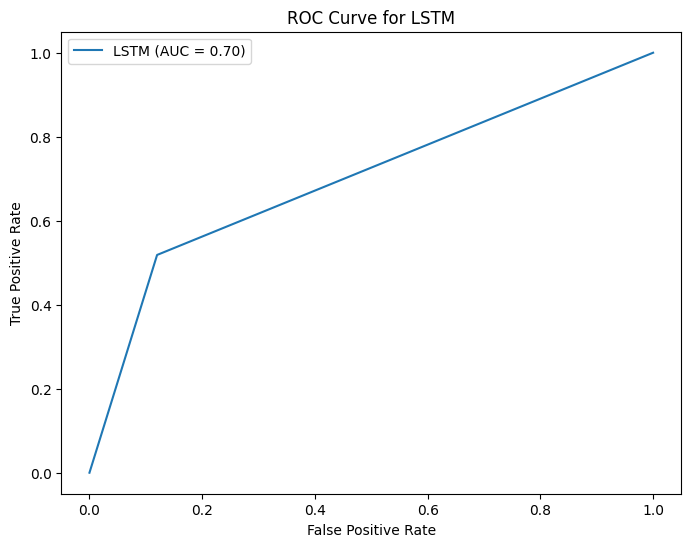

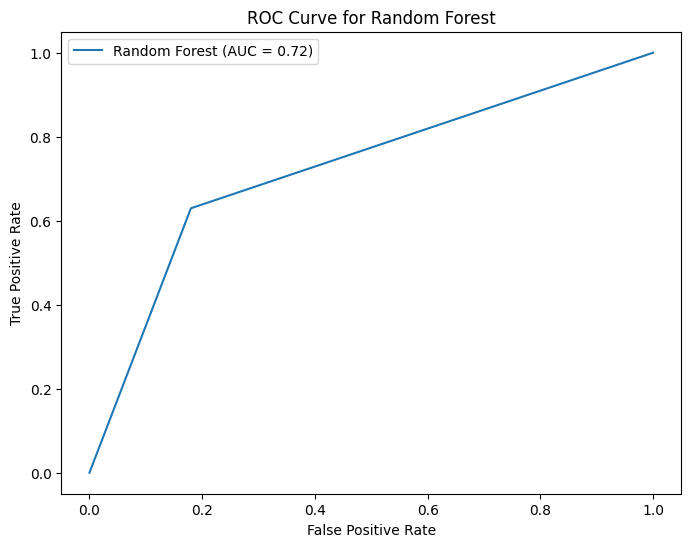

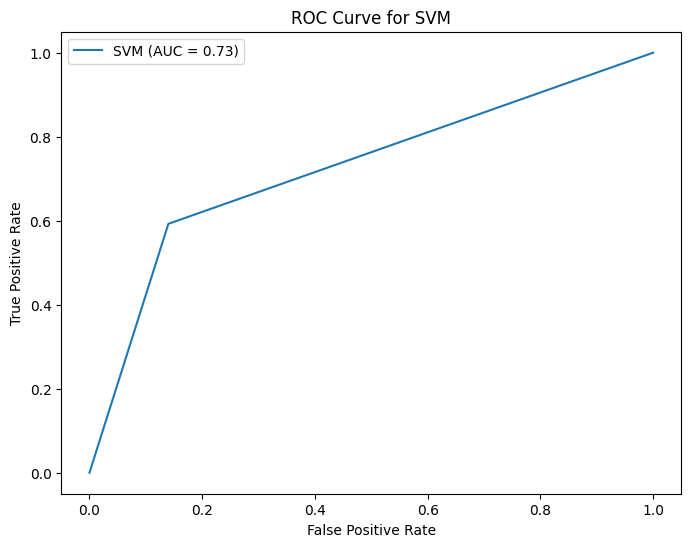

In [8]:
#Random Forest CLassifier
rf = RandomForestClassifier(n_estimators=80, criterion = "entropy", min_samples_split=5)
#Support Vector Classifier
sv = SVC(C=2,kernel="rbf")
#LSTM Neural Net
lstm = Sequential()
lstm.add(Input(shape=(1, 8)))
lstm.add(LSTM(64))
lstm.add(Dense(1))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#ROC curves with AUC values for each model on reruns
lstm_roc = roc(lstm, xtr, xte, ytr, yte, 1)
rf_roc = roc(rf, xtr, xte, ytr, yte, 0)
sv_roc = roc(sv, xtr, xte, ytr, yte, 0)

models = ['LSTM', 'Random Forest', 'SVM']
roc_list = [lstm_roc, rf_roc, sv_roc]

for x, y in zip(models, roc_list):
    fpr, tpr, _ = roc_curve(yte, y)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{x} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {x}')
    plt.legend()
    plt.show()